In [192]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [6]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [7]:
btc_trace = go.Scatter(x=data.index, y=data['exukus'], name= 'exu')
py.iplot([btc_trace])

In [8]:
data['exukus'].replace(0, np.nan, inplace=True)
data['exukus'].fillna(method='ffill', inplace=True)

In [9]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [10]:
values = data['exukus'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
values

array([[0.5942],
       [0.5956],
       [0.5977],
       ...,
       [0.7825],
       [0.7708],
       [0.7713]], dtype=float32)

In [12]:
scaled

array([[0.34262943],
       [0.34661353],
       [0.3525896 ],
       ...,
       [0.8784859 ],
       [0.8451905 ],
       [0.8466134 ]], dtype=float32)

In [13]:
#split dataset into train and test, 70% train 30% test

In [14]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [15]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 3 #use 3 previous days to predict the next day
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

5548
2377


In [17]:
trainX

array([[0.34262943, 0.34661353, 0.3525896 ],
       [0.34661353, 0.3525896 , 0.39328384],
       [0.3525896 , 0.39328384, 0.41605008],
       ...,
       [0.52105856, 0.51052916, 0.4874786 ],
       [0.51052916, 0.4874786 , 0.46784282],
       [0.4874786 , 0.46784282, 0.45702899]], dtype=float32)

In [18]:
trainY

array([0.39328384, 0.41605008, 0.40239036, ..., 0.46784282, 0.45702899,
       0.44223094], dtype=float32)

In [19]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
trainX

array([[[0.34262943, 0.34661353, 0.3525896 ]],

       [[0.34661353, 0.3525896 , 0.39328384]],

       [[0.3525896 , 0.39328384, 0.41605008]],

       ...,

       [[0.52105856, 0.51052916, 0.4874786 ]],

       [[0.51052916, 0.4874786 , 0.46784282]],

       [[0.4874786 , 0.46784282, 0.45702899]]], dtype=float32)

In [21]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5548 samples, validate on 2377 samples
Epoch 1/50
5548/5548 [==============================] - 2s 333us/step - loss: 0.2080 - val_loss: 0.0532
Epoch 2/50
5548/5548 [==============================] - 0s 77us/step - loss: 0.0593 - val_loss: 0.0657
Epoch 3/50
5548/5548 [==============================] - 0s 77us/step - loss: 0.0367 - val_loss: 0.0741
Epoch 4/50
5548/5548 [==============================] - 0s 77us/step - loss: 0.0236 - val_loss: 0.0407
Epoch 5/50
5548/5548 [==============================] - 0s 72us/step - loss: 0.0126 - val_loss: 0.0184
Epoch 6/50
5548/5548 [==============================] - 0s 73us/step - loss: 0.0124 - val_loss: 0.0179
Epoch 7/50
5548/5548 [==============================] - 0s 69us/step - loss: 0.0125 - val_loss: 0.0180
Epoch 8/50
5548/5548 [==============================] - 0s 68us/step - loss: 0.0121 - val_loss: 0.0173
Epoch 9/50
5548/5548 [==============================] - 0s 68us/step - loss: 0.0124 - val_loss: 0.0178
Epoch 10/50
5548/5548 [=

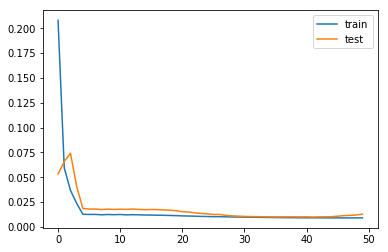

In [22]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

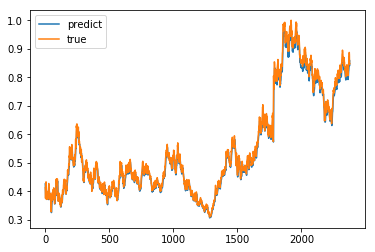

In [23]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [24]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [25]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.006


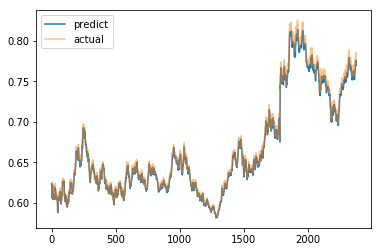

In [26]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [27]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [28]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

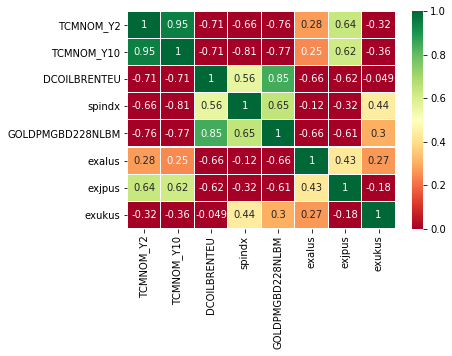

In [29]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [705]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [706]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [707]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [708]:
#normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [709]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [710]:
#convert data to become supervised 
look_back = 30
time_steps = 5
reframed = series_to_supervised(values, look_back, time_steps)
reframed

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var6(t-30),var7(t-30),var8(t-30),var1(t-29),var2(t-29),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
48,304.760010,7.47,8.28,18.900000,452.750000,1.3904,144.449997,0.6120,304.809998,7.42,...,150.500000,0.6315,316.230011,7.72,8.81,20.650000,473.399994,1.4308,152.100006,0.6369
49,304.809998,7.42,8.23,19.030001,451.250000,1.3829,144.649994,0.6119,305.690002,7.44,...,152.100006,0.6369,318.450012,7.65,8.71,19.799999,469.799988,1.4249,150.750000,0.6336
50,305.690002,7.44,8.27,19.049999,452.200012,1.3850,144.600006,0.6136,306.970001,7.45,...,150.750000,0.6336,322.089996,7.65,8.73,19.750000,468.700012,1.4300,151.449997,0.6345
51,306.970001,7.45,8.30,19.049999,449.000000,1.3868,145.050003,0.6188,309.649994,7.42,...,151.449997,0.6345,323.000000,7.69,8.70,19.650000,464.100006,1.4298,151.570007,0.6383
52,309.649994,7.42,8.23,19.100000,438.000000,1.3864,145.899994,0.6270,308.429993,7.45,...,151.570007,0.6383,328.000000,7.71,8.74,19.430000,461.100006,1.4337,151.119995,0.6383
53,308.429993,7.45,8.23,18.900000,440.200012,1.3957,146.029999,0.6254,306.859985,7.54,...,151.119995,0.6383,333.329987,7.69,8.73,19.450001,461.200012,1.4251,151.770004,0.6371
54,306.859985,7.54,8.31,18.750000,441.750000,1.3941,145.080002,0.6165,308.959991,7.47,...,151.770004,0.6371,332.390015,7.67,8.72,19.500000,463.399994,1.4235,151.250000,0.6333
55,308.959991,7.47,8.25,18.700001,440.500000,1.3885,146.330002,0.6203,307.160004,7.56,...,151.250000,0.6333,334.649994,7.64,8.63,19.400000,462.500000,1.4188,151.449997,0.6330
56,307.160004,7.56,8.37,19.080000,444.100006,1.3906,146.300003,0.6209,307.899994,7.48,...,151.449997,0.6330,333.989990,7.62,8.58,19.250000,460.000000,1.4116,150.000000,0.6293
57,307.899994,7.48,8.34,19.150000,449.750000,1.3873,146.699997,0.6247,304.000000,7.48,...,150.000000,0.6293,334.109985,7.62,8.56,18.850000,453.299988,1.4069,149.919998,0.6286


In [744]:
#look_back = 5
number_of_variables = 8
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True)
print(reframed.head())

    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
48  304.760010        7.47        8.28   18.900000  452.750000      1.3904   
49  304.809998        7.42        8.23   19.030001  451.250000      1.3829   
50  305.690002        7.44        8.27   19.049999  452.200012      1.3850   
51  306.970001        7.45        8.30   19.049999  449.000000      1.3868   
52  309.649994        7.42        8.23   19.100000  438.000000      1.3864   

    var7(t-30)  var8(t-30)  var1(t-29)  var2(t-29)  ...  var2(t-3)  var3(t-3)  \
48  144.449997      0.6120  304.809998        7.42  ...       7.53       8.58   
49  144.649994      0.6119  305.690002        7.44  ...       7.59       8.60   
50  144.600006      0.6136  306.970001        7.45  ...       7.61       8.62   
51  145.050003      0.6188  309.649994        7.42  ...       7.64       8.61   
52  145.899994      0.6270  308.429993        7.45  ...       7.63       8.61   

    var4(t-3)   var5(t-3)  var6(t-3)   var7(

In [745]:
reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)
print(reframed.head())

    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
48  304.760010        7.47        8.28   18.900000  452.750000      1.3904   
49  304.809998        7.42        8.23   19.030001  451.250000      1.3829   
50  305.690002        7.44        8.27   19.049999  452.200012      1.3850   
51  306.970001        7.45        8.30   19.049999  449.000000      1.3868   
52  309.649994        7.42        8.23   19.100000  438.000000      1.3864   

    var7(t-30)  var8(t-30)  var1(t-29)  var2(t-29)  ...  var2(t-3)  var3(t-3)  \
48  144.449997      0.6120  304.809998        7.42  ...       7.53       8.58   
49  144.649994      0.6119  305.690002        7.44  ...       7.59       8.60   
50  144.600006      0.6136  306.970001        7.45  ...       7.61       8.62   
51  145.050003      0.6188  309.649994        7.42  ...       7.64       8.61   
52  145.899994      0.6270  308.429993        7.45  ...       7.63       8.61   

    var4(t-3)   var5(t-3)  var6(t-3)   var7(

In [746]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [747]:
scaled.shape

(3721, 227)

In [748]:
#splitting data 
n_train_hours = int(len(scaled) * 0.7)

In [749]:
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [750]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# target = -1 * number_of_variables
# look_back = 1
# number_of_variables = 8
# train_X, train_y = train[:, :(look_back * number_of_variables)], train[:, -1]
# test_X, test_y = test[:, :(look_back * number_of_variables) ], test[:, -1]

In [751]:
train_X

array([[0.02971888, 0.79803494, 0.77990972, ..., 0.42967625, 0.03259901,
        0.78141502],
       [0.02973747, 0.79257645, 0.77426635, ..., 0.43597819, 0.03323047,
        0.78352695],
       [0.03006471, 0.79475986, 0.77878113, ..., 0.43483237, 0.03447835,
        0.78669482],
       ...,
       [0.25789454, 0.12227074, 0.28103838, ..., 0.38126604, 0.28236317,
        0.10348469],
       [0.25895804, 0.11899564, 0.27313771, ..., 0.39157828, 0.28672323,
        0.10559663],
       [0.24847537, 0.11026201, 0.26523704, ..., 0.38069322, 0.28699761,
        0.09926082]])

In [752]:
train_y

array([0.81602717, 0.81828445, 0.81715576, ..., 0.26185104, 0.2595937 ,
       0.24266367])

In [753]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2604, 1, 226) (2604,) (1117, 1, 226) (1117,)


In [754]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# multi_model.add(LSTM(100, return_sequences = True))
multi_model.add(Dense(1))
model.add(Dense(10, activation='softmax'))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)
multi_model.summary()

Train on 2604 samples, validate on 1117 samples
Epoch 1/50
2604/2604 [==============================] - 6s 2ms/step - loss: 0.1480 - val_loss: 0.1465
Epoch 2/50
2604/2604 [==============================] - 0s 85us/step - loss: 0.1332 - val_loss: 0.1488
Epoch 3/50
2604/2604 [==============================] - 0s 83us/step - loss: 0.1993 - val_loss: 0.1140
Epoch 4/50
2604/2604 [==============================] - 0s 86us/step - loss: 0.0656 - val_loss: 0.0623
Epoch 5/50
2604/2604 [==============================] - 0s 86us/step - loss: 0.0733 - val_loss: 0.0845
Epoch 6/50
2604/2604 [==============================] - 0s 86us/step - loss: 0.1939 - val_loss: 0.1111
Epoch 7/50
2604/2604 [==============================] - 0s 86us/step - loss: 0.0929 - val_loss: 0.0876
Epoch 8/50
2604/2604 [==============================] - 0s 88us/step - loss: 0.1672 - val_loss: 0.1321
Epoch 9/50
2604/2604 [==============================] - 0s 87us/step - loss: 0.0385 - val_loss: 0.0524
Epoch 10/50
2604/2604 [===

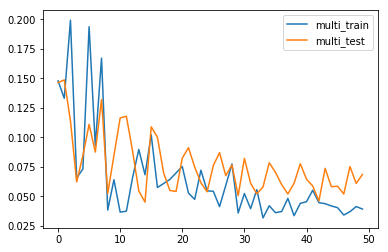

In [755]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

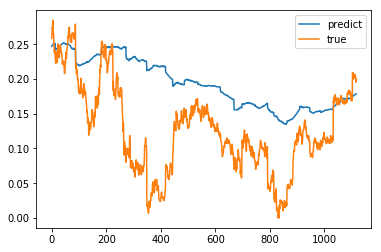

In [756]:
#plot prediction
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [757]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [758]:
test_X

array([[0.2492414 , 0.1069869 , 0.25733637, ..., 0.35663128, 0.29269201,
        0.10454065],
       [0.25141306, 0.11244543, 0.26523704, ..., 0.33228301, 0.29382714,
        0.10665259],
       [0.25859735, 0.1048035 , 0.24604967, ..., 0.33457466, 0.29272583,
        0.10982049],
       ...,
       [0.99633344, 0.2838428 , 0.18058692, ..., 0.85075908, 0.94597277,
        0.28511089],
       [0.99663095, 0.28602621, 0.18284425, ..., 0.84932676, 0.91417817,
        0.27983104],
       [0.99061431, 0.28602621, 0.18284425, ..., 0.86364946, 0.93277234,
        0.28194297]])

In [759]:
#test_X[:, 1:]
yhat

array([[0.24720934],
       [0.24779573],
       [0.24777937],
       ...,
       [0.17806607],
       [0.17843038],
       [0.1786395 ]], dtype=float32)

In [760]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)

In [761]:
inv_yhat.shape

(1117, 227)

In [762]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [763]:
inv_yhat = inv_yhat[:,0]

In [764]:
inv_yhat

array([889.63536493, 891.21228627, 891.16828699, ..., 703.69529243,
       704.67497765, 705.23735096])

In [765]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))

In [766]:
inv_y = concatenate((test_y, test_X[:, :]), axis=1)

In [767]:
inv_y

array([[0.25846503, 0.2492414 , 0.1069869 , ..., 0.35663128, 0.29269201,
        0.10454065],
       [0.2629797 , 0.25141306, 0.11244543, ..., 0.33228301, 0.29382714,
        0.10665259],
       [0.27426637, 0.25859735, 0.1048035 , ..., 0.33457466, 0.29272583,
        0.10982049],
       ...,
       [0.20316029, 0.99633344, 0.2838428 , ..., 0.85075908, 0.94597277,
        0.28511089],
       [0.19525959, 0.99663095, 0.28602621, ..., 0.84932676, 0.91417817,
        0.27983104],
       [0.19977429, 0.99061431, 0.28602621, ..., 0.86364946, 0.93277234,
        0.28194297]])

In [768]:
inv_y = scaler.inverse_transform(inv_y)

In [769]:
inv_y

array([[9.19904177e+02, 2.44305113e+00, 2.31790391e+00, ...,
        1.17274105e+03, 2.96179331e+00, 2.29623012e+00],
       [9.32045024e+02, 2.46294353e+00, 2.36626642e+00, ...,
        1.10796225e+03, 2.97254297e+00, 2.31494194e+00],
       [9.62397141e+02, 2.52875167e+00, 2.29855895e+00, ...,
        1.11405919e+03, 2.96211354e+00, 2.34300949e+00],
       ...,
       [7.71178656e+02, 9.28641403e+00, 3.88484711e+00, ...,
        2.48737299e+03, 9.14836196e+00, 3.89608238e+00],
       [7.49932101e+02, 9.28913917e+00, 3.90419207e+00, ...,
        2.48356229e+03, 8.84726712e+00, 3.84930290e+00],
       [7.62073020e+02, 9.23402680e+00, 3.90419207e+00, ...,
        2.52166798e+03, 9.02335390e+00, 3.86801460e+00]])

In [770]:
inv_y = inv_y[:,0]

In [771]:
inv_y

array([919.90417662, 932.04502366, 962.39714125, ..., 771.1786557 ,
       749.93210102, 762.07302042])

In [772]:
inv_yhat

array([889.63536493, 891.21228627, 891.16828699, ..., 703.69529243,
       704.67497765, 705.23735096])

In [773]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 228.295


In [774]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])